In [ ]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Data Engineering
  
the order variable will be use later on to do mapping, so we have to make sure it is in the correct order when we transform the data

In [2]:
data_path = '../data/hsf_7'
order = '0123456789abcdefghijklmnopqrstuvwxyz'

Here are the setting for feature engineering, I reduce the image to half (128x128 - 64x64) because my machine cannot handle it that big, 64 is the max I can go. Feel to try it on bigger size if you have better machine. You can reduce to 28x28 it if you machine cannot handle it.
  
Remember, when you reduce an image size, there will be an information loss. I prefer to keep it in original size if I could.

In [3]:
#DATA SETTINGS
x = []
y = []
WIDTH = 64
HEIGHT = 64
DIM = (WIDTH,HEIGHT)
TARGET_SIZE = 36

This might be not the most optimal way of reading data but, I dont want to spent to much time renaming and checking folders order. You can combine reading digits and aplhabets together but you have to make sure it labeled correctly.

In [4]:
#reading digit
for i,folder in enumerate(sorted(os.listdir(data_path+'/digit'))):
    for file in os.listdir(data_path+'/digit/'+folder):
        file_path = data_path+'/digit/'+folder+'/'+file
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, DIM, interpolation = cv2.INTER_AREA)
        label = i
#         plt.figure()
#         plt.title(i)
#         plt.imshow(img)
        x.append(img)
        y.append(i)

In [5]:
alphabets = []
for i,folder in enumerate(sorted(os.listdir(data_path+'/upper'))):
    for file in os.listdir(data_path+'/upper/'+folder):
        file_path = data_path+'/upper/'+folder+'/'+file
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, DIM, interpolation = cv2.INTER_AREA)
        label = i+10
#         plt.figure()
#         plt.title(i)
#         plt.imshow(img)
        x.append(img)
        y.append(i+10)

We will need to use numpy because we will be reshaping the array later on

In [6]:
x = np.array(x)
y = np.array(to_categorical(y))

Checking target size is the same as what we expected - 26 alphabets + 10 digits 

In [48]:
print(f"Target size is {len(y[0])}")

Target size is 36


Now we will be split the data into training and testing(validation), 

random_state - basically just a pseudo number that will make the splitting will be the same on a different run, you can remove it if you want to make it 100% random

why 42 ? Its quite funny though, it comes from a novel. [Here](https://en.wikipedia.org/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy)'s the source.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [25]:
X_train = X_train.reshape(-1,WIDTH,HEIGHT,1)
y_train = y_train.reshape(-1,TARGET_SIZE)

X_test = X_test.reshape(-1,WIDTH,HEIGHT,1)
y_test = y_test.reshape(-1,TARGET_SIZE)

In [49]:
print(f"X train shape {X_train.shape}")
print(f"y train shape {y_train.shape}")
print()
print(f"X test shape {X_test.shape}")
print(f"y test shape {y_test.shape}")

X train shape (64962, 64, 64, 1)
y train shape (64962, 36)

X test shape (7219, 64, 64, 1)
y test shape (7219, 36)


A good source explaining [ImageDataGenerator](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

Basically, it helps feeding image data into your model with some customization on the image along the way to generalize the model.

In [40]:
datagen = ImageDataGenerator(
        zoom_range = 0.2,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        brightness_range=(0.5,1.5))



In [41]:
datagen.fit(X_train)

In [42]:
#Model Settings
EPOCHS = 30
BATCH_SIZE = 64

In [43]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu',
                 input_shape = (WIDTH,HEIGHT,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(CHARACTER_SIZE, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 32)        25632     
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 32)       

In [44]:
model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [45]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS,
#                               batch_size=BATCH_SIZE,
                              validation_data = (X_test,y_test),
                              verbose = 1,
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                              callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                               patience=5,
                               verbose=1,
                               factor=0.5,
                               min_lr=0.000001)])

Epoch 1/30
1015/1015 [==============================] - 83s 82ms/step - loss: 1.9503 - accuracy: 0.5991 - val_loss: 0.6972 - val_accuracy: 0.8521
Epoch 2/30
1015/1015 [==============================] - 81s 80ms/step - loss: 0.5985 - accuracy: 0.8486 - val_loss: 0.2779 - val_accuracy: 0.9253
Epoch 3/30
1015/1015 [==============================] - 81s 80ms/step - loss: 0.4021 - accuracy: 0.8927 - val_loss: 15.4041 - val_accuracy: 0.0256
Epoch 4/30
1015/1015 [==============================] - 81s 80ms/step - loss: 0.3145 - accuracy: 0.9129 - val_loss: 0.7120 - val_accuracy: 0.7680
Epoch 5/30
1015/1015 [==============================] - 84s 82ms/step - loss: 0.2818 - accuracy: 0.9220 - val_loss: 0.1345 - val_accuracy: 0.9620
Epoch 6/30
1015/1015 [==============================] - 84s 83ms/step - loss: 0.2522 - accuracy: 0.9302 - val_loss: 0.1952 - val_accuracy: 0.9415
Epoch 7/30
1015/1015 [==============================] - 83s 82ms/step - loss: 0.2347 - accuracy: 0.9341 - val_loss: 0.1692 

# Model Evaluation

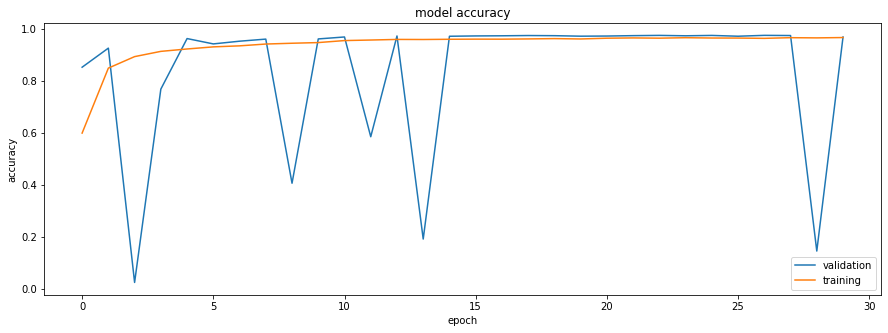

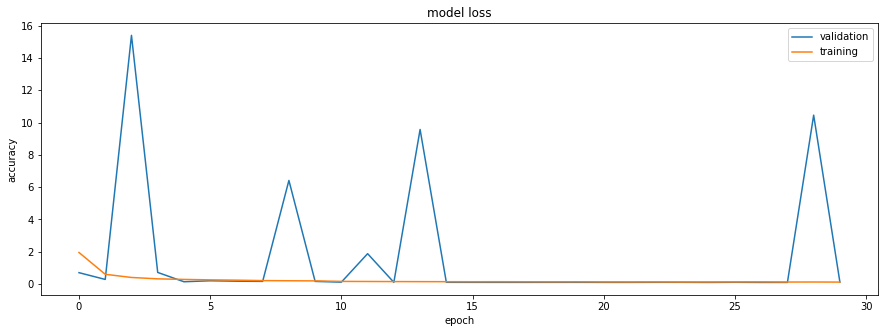

In [50]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.plot(history.history['accuracy'], label = 'training')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
axes = plt.gca()
# axes.set_ylim([0.98,1])

plt.figure(figsize=(15,5))
plt.plot(history.history['val_loss'], label = 'validation')
plt.plot(history.history['loss'], label = 'training')
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Well not so bad, but I prefer a smoother learning. WIP, tweaking the dropout and layer of model

In [56]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

7219/7219 [==============================] - 3s 447us/step
accuracy: 96.81%


In [57]:
#TODO: Confusion Matrix

# Saving Model

Various way loading model can be found [here](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)
  
I chose to save model including with weights as it will ease the process to load it later on

In [51]:
model.save("../data/ocr_model.h5")
print("Saved model to disk")


Saved model to disk
